# Baseline Models for Time Series Forecasting

This notebook demonstrates baseline forecasting models including:

1. **Naive Model** - Last observed value as prediction
2. **Seasonal Naive** - Value from same period in previous cycle
3. **Drift Model** - Naive with linear trend
4. **Moving Average (SMA)** - Simple moving average
5. **Exponential Moving Average (EMA)** - Weighted moving average

Baseline models provide a benchmark to compare against more sophisticated models (ARIMA, Prophet, LSTM).

## Setup

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add project root to path
sys.path.insert(0, os.path.dirname(os.getcwd()))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Project modules
import config
from src.data_cleaning import cleaned_data_loader
from src.models.baseline import (
    train_test_split,
    NaiveModel,
    SeasonalNaiveModel,
    MovingAverageModel,
    ExponentialMovingAverageModel,
    DriftModel,
    evaluate_baseline,
    run_all_baselines,
    forecast_future
)

# Plot settings
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print(f"Configuration:")
print(f"  Train/Test Split: {config.TRAIN_TEST_SPLIT}")
print(f"  Moving Average Window: {config.MOVING_AVERAGE_WINDOW}")
print(f"  Prediction Horizon: {config.PREDICTION_HORIZON_DAYS} days")

Configuration:
  Train/Test Split: 0.8
  Moving Average Window: 30
  Prediction Horizon: 20 days


## Load Data

In [2]:
# Load cleaned data
data = cleaned_data_loader()

print(f"\nData shape: {data.shape}")
print(f"Date range: {data.index.min()} to {data.index.max()}")
data.tail()

Loading cleaned data from: data/processed\cleaned_data_20260120_010244.csv
Loaded 1519 data points
Date range: 2020-01-02 00:00:00 to 2026-01-16 00:00:00
Columns: Open, High, Low, Close, Volume

Data shape: (1519, 5)
Date range: 2020-01-02 00:00:00 to 2026-01-16 00:00:00


,Open,High,Low,Close,Volume
Date,,,,,
2026-01-12,259.160004,261.299988,256.799988,260.250000,45263800
2026-01-13,258.720001,261.809998,258.390015,261.049988,45730800
2026-01-14,259.489990,261.820007,256.709991,259.959991,40019400
2026-01-15,260.649994,261.040009,257.049988,258.209991,39388600
2026-01-16,257.899994,258.899994,254.929993,255.529999,72018600


## Train/Test Split

Time series data must be split chronologically (no random shuffling).

Train/Test Split:
  Train: 1215 samples (2020-01-02 to 2024-10-29)
  Test: 304 samples (2024-10-30 to 2026-01-16)


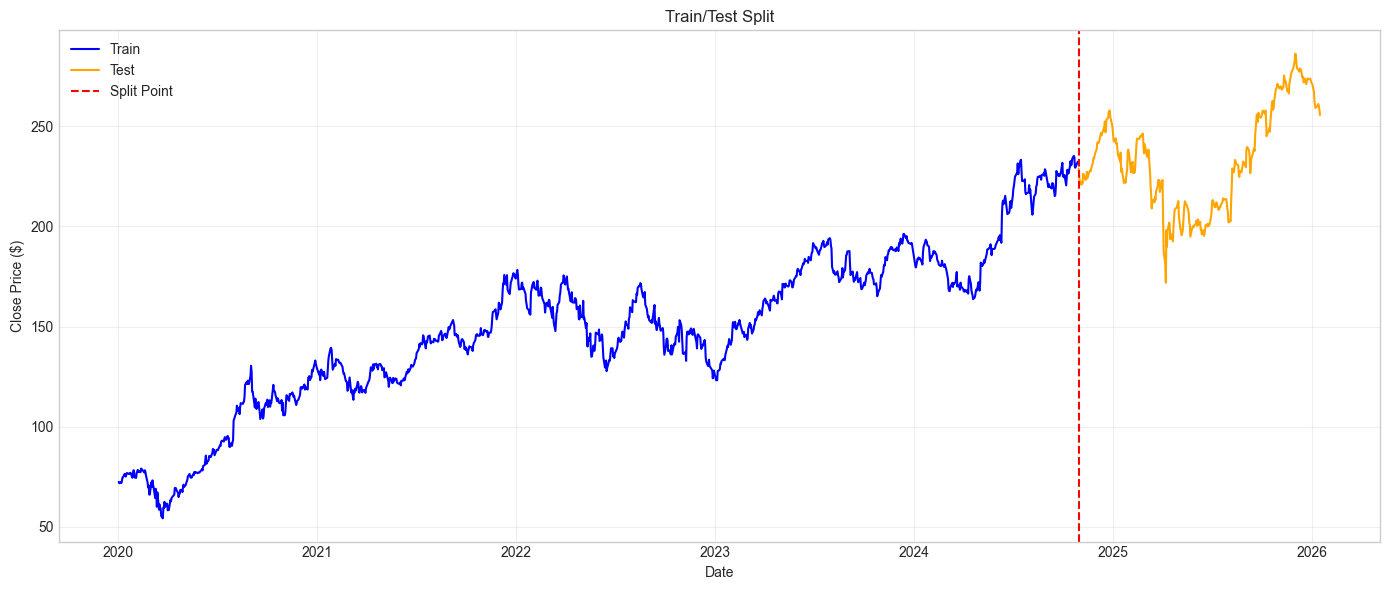

In [3]:
# Split data (80% train, 20% test)
train, test = train_test_split(data, train_ratio=0.8)

# Visualize split
fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(train.index, train['Close'], label='Train', color='blue')
ax.plot(test.index, test['Close'], label='Test', color='orange')
ax.axvline(x=test.index[0], color='red', linestyle='--', label='Split Point')
ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.set_title('Train/Test Split')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 1. Naive Model

The simplest baseline: predict the last observed value for all future points.

In [4]:
# Fit naive model
naive = NaiveModel()
naive.fit(train, column='Close')

# Evaluate
naive_results = evaluate_baseline(naive, test, column='Close')

Naive Model fitted. Last value: $232.36

Naive Evaluation:
  MAE: $21.08
  RMSE: $25.19
  MAPE: 9.08%


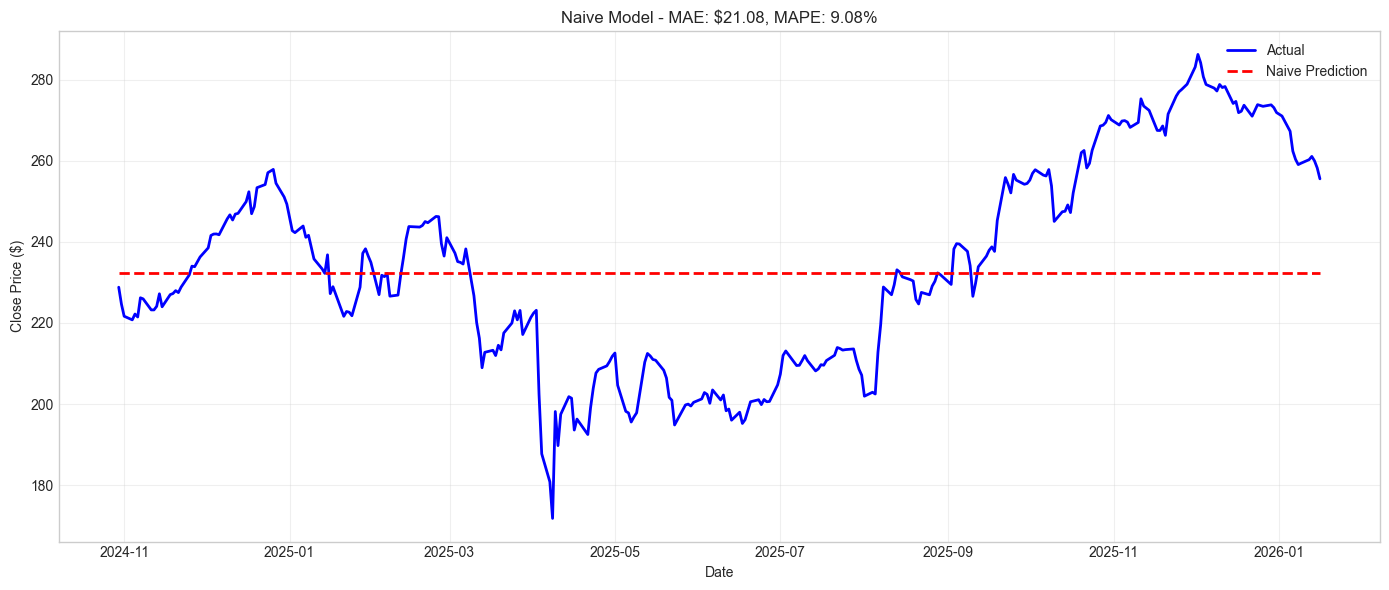

In [5]:
# Plot naive predictions
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(test.index, test['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(test.index, naive_results['predictions'], label='Naive Prediction', 
        color='red', linestyle='--', linewidth=2)

ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.set_title(f'Naive Model - MAE: ${naive_results["mae"]:.2f}, MAPE: {naive_results["mape"]:.2f}%')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 2. Moving Average Model

Predicts using the average of the last N observations.

In [6]:
# Test different window sizes
windows = [7, 14, 30, 60]
ma_results = {}

for window in windows:
    ma = MovingAverageModel(window=window)
    ma.fit(train, column='Close')
    ma_results[window] = evaluate_baseline(ma, test, column='Close')
    ma_results[window]['model'] = ma

Moving Average Model fitted. Window: 7, Current MA: $231.86

Moving Average (window=7) Evaluation:
  MAE: $21.08
  RMSE: $25.26
  MAPE: 9.04%
Moving Average Model fitted. Window: 14, Current MA: $231.04

Moving Average (window=14) Evaluation:
  MAE: $21.07
  RMSE: $25.24
  MAPE: 9.04%
Moving Average Model fitted. Window: 30, Current MA: $228.10

Moving Average (window=30) Evaluation:
  MAE: $21.12
  RMSE: $25.48
  MAPE: 8.99%
Moving Average Model fitted. Window: 60, Current MA: $224.37

Moving Average (window=60) Evaluation:
  MAE: $21.46
  RMSE: $26.06
  MAPE: 9.03%


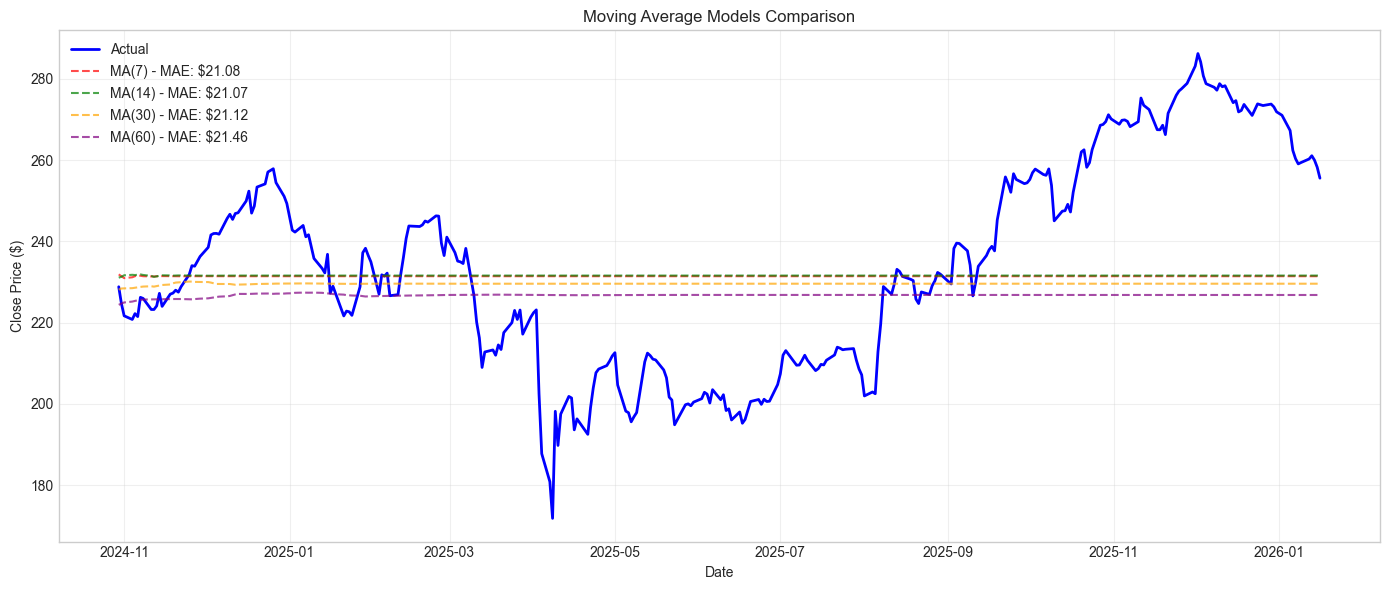

In [7]:
# Plot MA comparisons
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(test.index, test['Close'], label='Actual', color='blue', linewidth=2)

colors = ['red', 'green', 'orange', 'purple']
for i, window in enumerate(windows):
    ax.plot(test.index, ma_results[window]['predictions'], 
            label=f'MA({window}) - MAE: ${ma_results[window]["mae"]:.2f}',
            linestyle='--', color=colors[i], alpha=0.7)

ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.set_title('Moving Average Models Comparison')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# MA performance by window size
ma_df = pd.DataFrame([
    {'Window': w, 'MAE': r['mae'], 'RMSE': r['rmse'], 'MAPE': r['mape']}
    for w, r in ma_results.items()
])
print("Moving Average Performance by Window Size:")
print(ma_df.to_string(index=False))

Moving Average Performance by Window Size:
 Window       MAE      RMSE     MAPE
      7 21.077472 25.256699 9.040041
     14 21.073859 25.244242 9.044643
     30 21.122062 25.478428 8.986819
     60 21.463803 26.062737 9.027267


## 3. Exponential Moving Average (EMA)

Gives more weight to recent observations.

In [9]:
# Fit EMA model
ema = ExponentialMovingAverageModel(span=30)
ema.fit(train, column='Close')
ema_results = evaluate_baseline(ema, test, column='Close')

EMA Model fitted. Span: 30, Alpha: 0.0645, Last EMA: $228.30

EMA (span=30) Evaluation:
  MAE: $21.27
  RMSE: $25.72
  MAPE: 9.00%


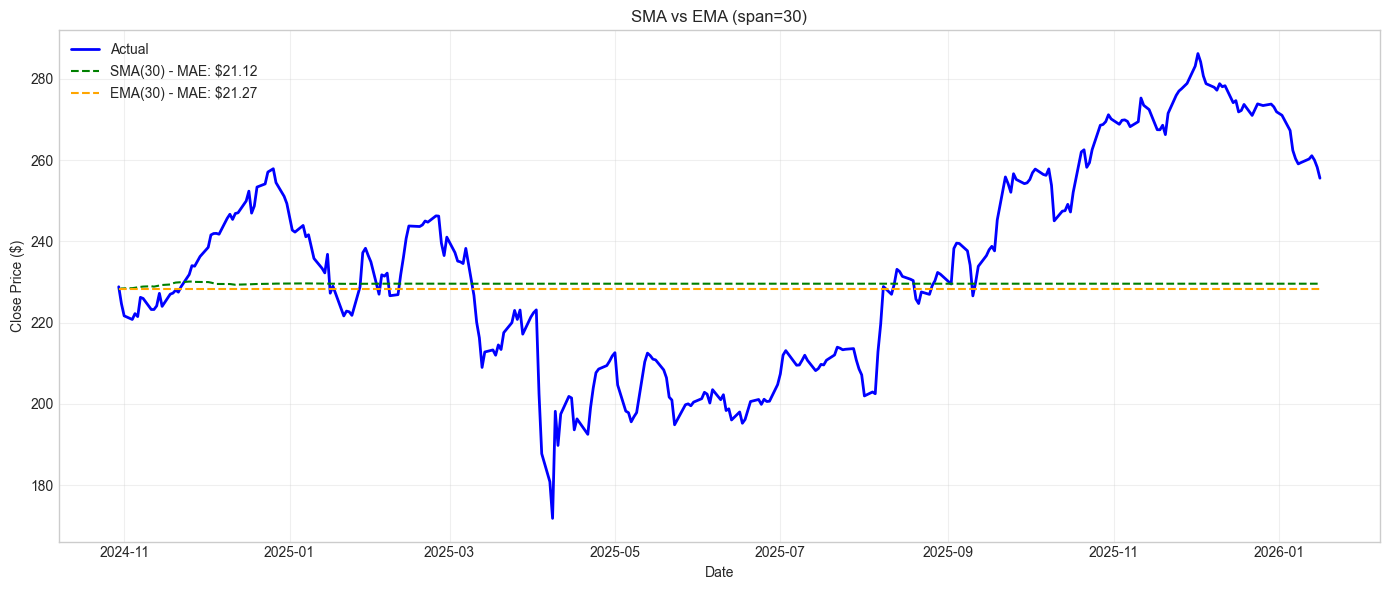

In [10]:
# Compare SMA vs EMA
sma_30 = ma_results[30]

fig, ax = plt.subplots(figsize=(14, 6))
ax.plot(test.index, test['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(test.index, sma_30['predictions'], label=f'SMA(30) - MAE: ${sma_30["mae"]:.2f}',
        linestyle='--', color='green')
ax.plot(test.index, ema_results['predictions'], label=f'EMA(30) - MAE: ${ema_results["mae"]:.2f}',
        linestyle='--', color='orange')

ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.set_title('SMA vs EMA (span=30)')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Drift Model

Naive model with a linear trend adjustment.

In [11]:
# Fit drift model
drift = DriftModel()
drift.fit(train, column='Close')
drift_results = evaluate_baseline(drift, test, column='Close')

Drift Model fitted. Last: $232.36, Drift: $0.1317/day

Drift Evaluation:
  MAE: $22.38
  RMSE: $29.07
  MAPE: 10.45%


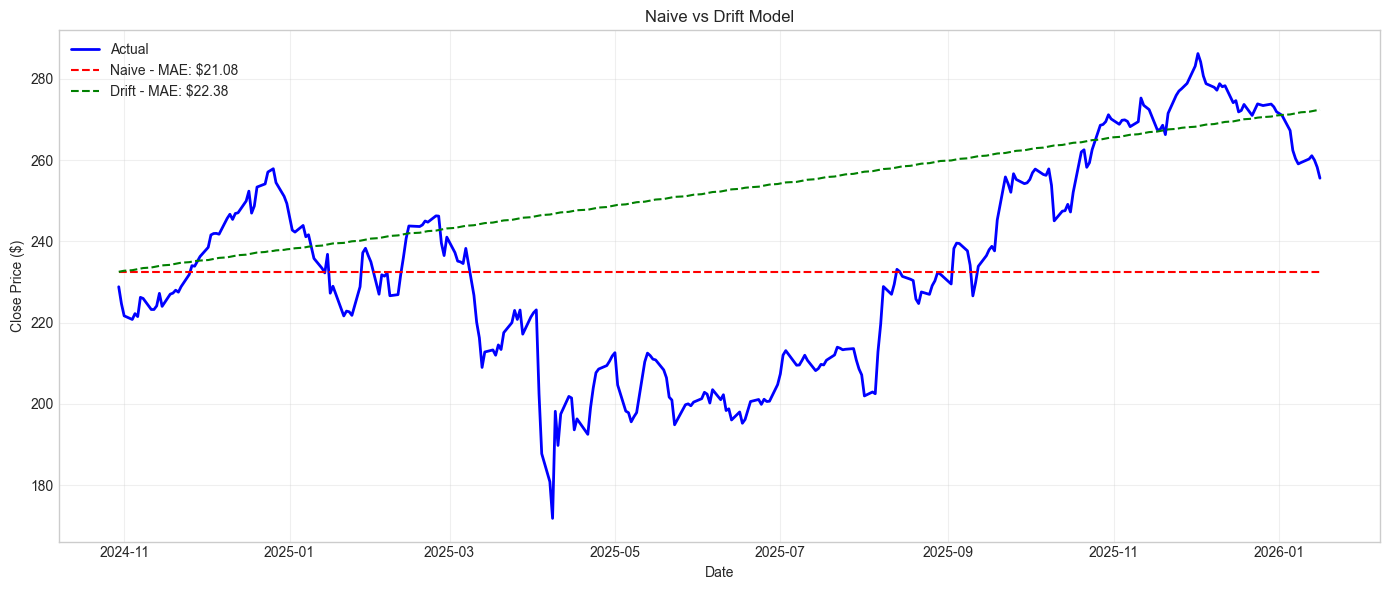

In [12]:
# Plot drift vs naive
fig, ax = plt.subplots(figsize=(14, 6))

ax.plot(test.index, test['Close'], label='Actual', color='blue', linewidth=2)
ax.plot(test.index, naive_results['predictions'], label=f'Naive - MAE: ${naive_results["mae"]:.2f}',
        linestyle='--', color='red')
ax.plot(test.index, drift_results['predictions'], label=f'Drift - MAE: ${drift_results["mae"]:.2f}',
        linestyle='--', color='green')

ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.set_title('Naive vs Drift Model')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Seasonal Naive

Uses value from the same period in the previous cycle (e.g., same day last week).

In [13]:
# Fit seasonal naive (period=5 for weekly trading days)
seasonal = SeasonalNaiveModel(seasonal_period=5)
seasonal.fit(train, column='Close')
seasonal_results = evaluate_baseline(seasonal, test, column='Close')

Seasonal Naive Model fitted. Period: 5

Seasonal Naive (period=5) Evaluation:
  MAE: $21.17
  RMSE: $25.37
  MAPE: 9.05%


## Run All Baselines

In [14]:
# Run all baselines and compare
all_results = run_all_baselines(data, column='Close', ma_windows=[7, 14, 30])


BASELINE MODELS COMPARISON
Train/Test Split:
  Train: 1215 samples (2020-01-02 to 2024-10-29)
  Test: 304 samples (2024-10-30 to 2026-01-16)

--- Naive Model ---
Naive Model fitted. Last value: $232.36

Naive Evaluation:
  MAE: $21.08
  RMSE: $25.19
  MAPE: 9.08%

--- Seasonal Naive Model ---
Seasonal Naive Model fitted. Period: 5

Seasonal Naive (period=5) Evaluation:
  MAE: $21.17
  RMSE: $25.37
  MAPE: 9.05%

--- Drift Model ---
Drift Model fitted. Last: $232.36, Drift: $0.1317/day

Drift Evaluation:
  MAE: $22.38
  RMSE: $29.07
  MAPE: 10.45%

--- Moving Average (window=7) ---
Moving Average Model fitted. Window: 7, Current MA: $231.86

Moving Average (window=7) Evaluation:
  MAE: $21.08
  RMSE: $25.26
  MAPE: 9.04%

--- Moving Average (window=14) ---
Moving Average Model fitted. Window: 14, Current MA: $231.04

Moving Average (window=14) Evaluation:
  MAE: $21.07
  RMSE: $25.24
  MAPE: 9.04%

--- Moving Average (window=30) ---
Moving Average Model fitted. Window: 30, Current MA: 

## Model Comparison Visualization

In [15]:
# Create comparison dataframe
comparison_data = []
for key, res in all_results.items():
    if not key.startswith('_'):
        comparison_data.append({
            'Model': res['model'],
            'MAE': res['mae'],
            'RMSE': res['rmse'],
            'MAPE': res['mape']
        })

comparison_df = pd.DataFrame(comparison_data).sort_values('MAE')
comparison_df

,Model,MAE,RMSE,MAPE
4,Moving Average (window=14),21.073859,25.244242,9.044643
0,Naive,21.075156,25.191783,9.076321
3,Moving Average (window=7),21.077472,25.256699,9.040041
5,Moving Average (window=30),21.122062,25.478428,8.986819
1,Seasonal Naive (period=5),21.167157,25.365563,9.049516
6,EMA (span=30),21.270608,25.716642,9.002276
2,Drift,22.379737,29.067305,10.450258


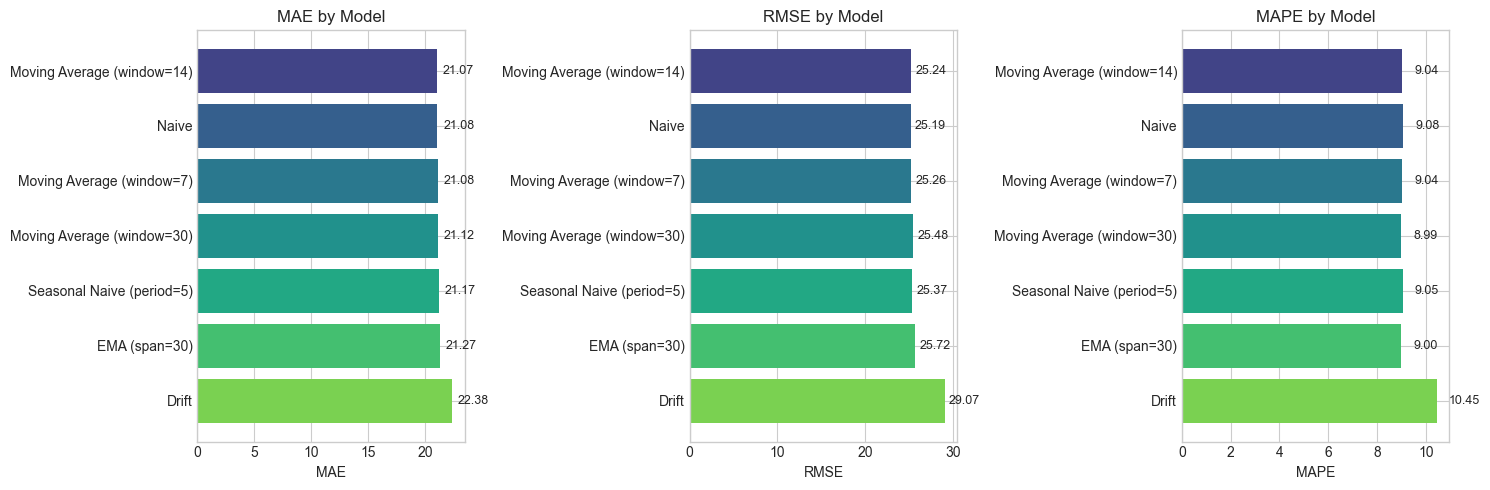

In [16]:
# Bar chart comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['MAE', 'RMSE', 'MAPE']
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))

for ax, metric in zip(axes, metrics):
    bars = ax.barh(comparison_df['Model'], comparison_df[metric], color=colors)
    ax.set_xlabel(metric)
    ax.set_title(f'{metric} by Model')
    ax.invert_yaxis()
    
    # Add value labels
    for bar, val in zip(bars, comparison_df[metric]):
        ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

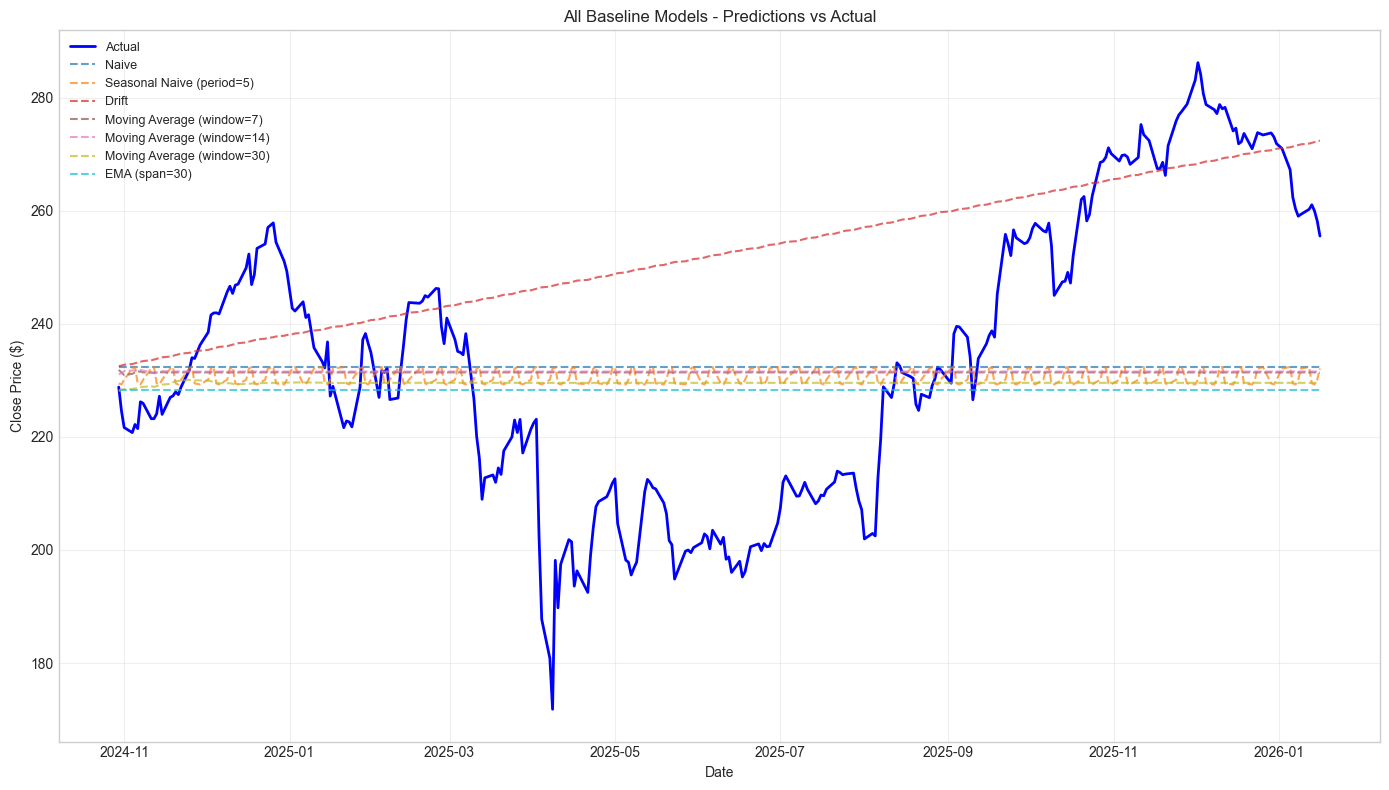

In [17]:
# All predictions on one plot
test_data = all_results['_test']

fig, ax = plt.subplots(figsize=(14, 8))
ax.plot(test_data.index, test_data['Close'], label='Actual', color='blue', linewidth=2)

colors = plt.cm.tab10(np.linspace(0, 1, 7))
i = 0
for key, res in all_results.items():
    if not key.startswith('_'):
        ax.plot(test_data.index, res['predictions'], 
                label=f"{res['model']}", linestyle='--', alpha=0.7, color=colors[i])
        i += 1

ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.set_title('All Baseline Models - Predictions vs Actual')
ax.legend(loc='upper left', fontsize=9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Error Analysis

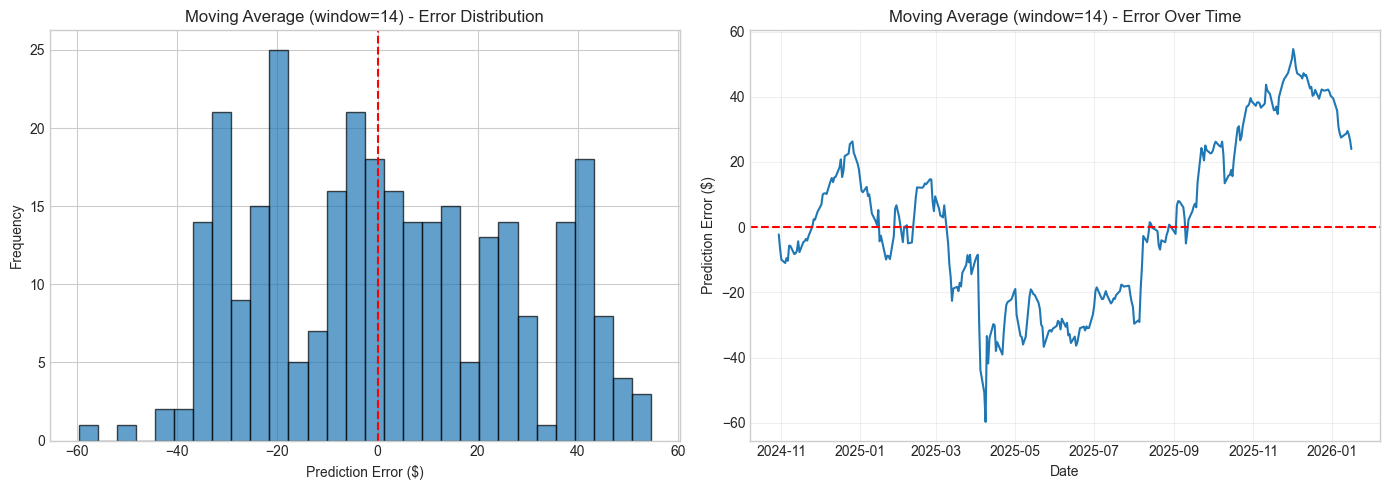

In [18]:
# Error distribution for best model
best_key = comparison_df.iloc[0]['Model']
best_result = [r for r in all_results.values() if isinstance(r, dict) and r.get('model') == best_key][0]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Error histogram
axes[0].hist(best_result['errors'], bins=30, edgecolor='black', alpha=0.7)
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_xlabel('Prediction Error ($)')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'{best_key} - Error Distribution')

# Error over time
axes[1].plot(test_data.index, best_result['errors'])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Prediction Error ($)')
axes[1].set_title(f'{best_key} - Error Over Time')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Future Forecast

In [19]:
# Get best model and forecast
best_model_key = min(
    [k for k in all_results.keys() if not k.startswith('_')],
    key=lambda k: all_results[k]['mae']
)
best_model = all_results[best_model_key]['model_obj']

# Generate forecast
forecast = forecast_future(best_model, horizon=20, last_date=data.index[-1])
forecast


Moving Average (window=14) - 20-day Forecast:
              forecast
2026-01-19  231.043987
2026-01-20  231.278685
2026-01-21  231.635983
2026-01-22  231.752442
2026-01-23  231.696098
2026-01-26  231.782758
2026-01-27  231.849328
2026-01-28  231.718220
2026-01-29  231.472624
2026-01-30  231.253524
... (10 more rows)


,forecast
2026-01-19,231.043987
2026-01-20,231.278685
2026-01-21,231.635983
2026-01-22,231.752442
2026-01-23,231.696098
2026-01-26,231.782758
2026-01-27,231.849328
2026-01-28,231.718220
2026-01-29,231.472624
2026-01-30,231.253524


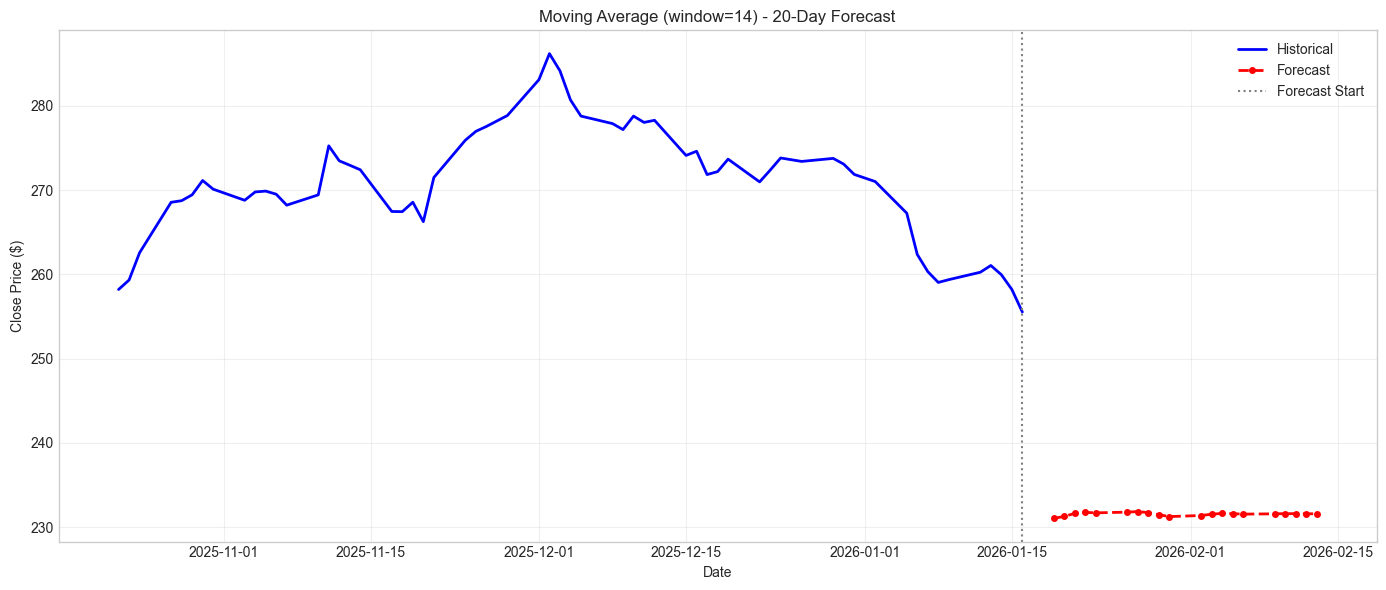

In [20]:
# Plot forecast
fig, ax = plt.subplots(figsize=(14, 6))

# Last 60 days of historical data
recent_data = data.iloc[-60:]
ax.plot(recent_data.index, recent_data['Close'], label='Historical', color='blue', linewidth=2)

# Forecast
ax.plot(forecast.index, forecast['forecast'], label='Forecast', 
        color='red', linestyle='--', linewidth=2, marker='o', markersize=4)

ax.axvline(x=data.index[-1], color='gray', linestyle=':', label='Forecast Start')

ax.set_xlabel('Date')
ax.set_ylabel('Close Price ($)')
ax.set_title(f'{best_model.name} - 20-Day Forecast')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Summary

Baseline models provide a simple benchmark for forecasting. Key takeaways:

- **Best Model**: Usually Moving Average or Naive for stock prices
- **Use Case**: Benchmark to beat with ARIMA, Prophet, LSTM
- **Limitation**: Don't capture complex patterns or external factors

In [21]:
# Final summary
print("=" * 60)
print("BASELINE MODELS SUMMARY")
print("=" * 60)
print(f"\nBest Model: {best_model.name}")
print(f"MAE: ${all_results[best_model_key]['mae']:.2f}")
print(f"RMSE: ${all_results[best_model_key]['rmse']:.2f}")
print(f"MAPE: {all_results[best_model_key]['mape']:.2f}%")
print(f"\nThis provides the benchmark to beat with advanced models.")

BASELINE MODELS SUMMARY

Best Model: Moving Average (window=14)
MAE: $21.07
RMSE: $25.24
MAPE: 9.04%

This provides the benchmark to beat with advanced models.
